In [1]:
import sta_clustering_core

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print(sta_clustering_core.__version__)

2.0.3


In [3]:
print(pd.__version__)

1.1.0


#### Preparation
* Load data into Python
* Drop empty or very short texts
* Choose number of clusters (e.g. 12)

#### Clustering
* Create the *feature matrix* by converting the text content into a word frequency map with tf-idf weighting
* Cluster the documents using non-negative matrix factorisation (NMF)
* Inspect the resulting compressed matrices to determine
    * Cluster assignment of each document
    * Cluster size
    * Top words for each cluster
    
#### Visualise the results
* Confusion matrix
* Positions of clusters in the latent space (pyLDAvis)

In [4]:
from typing import List
from sta_clustering_core.core.datamodel import RefCase

def df_to_refcases(df: pd.DataFrame) -> List[RefCase]:
    """Converts the dataframe to RefCases, the internal format for STA"""
    result = []
    for _idx, row in df.iterrows():
        try:
            result.append(RefCase(
                _idx,  # row['Case Number'],
                row['Machine Translation (beta): English'],  # row['Subject'],
                '',  # row['Description'],
                '',  # row['Solution Description'],
                [],  # parse_entity_list(row['Subject_entities']),
                [],  # parse_entity_list(row['Desc_entities']),
                [],  # parse_entity_list(row['Soln_entities']),
                '',  # row['Product Family'],
                ''  # row['Equipment: Serial Number']
            ))
        except UnicodeError as ue:
            print(ue)
            print(row)
            
    return result

In [5]:
data_path = '/home/z0017wrp/work/projects/sges_sop_it/ct mvp data from teams 20200811/CT MVP/'
files = [
    ('sges1_2019', 2019, 'SGES 1 2019 Q3 English Beta.xlsx'),
    ('sges2_2019', 2019, 'SGES 2 2019 Q4 English Beta.xlsx'),
    ('sges3_2020', 2020, 'SGES 3 2020 Q1 English Beta.xlsx')
]

data_by_survey_code = []
for survey_code, year, filename in files:
    datafr = pd.read_excel(data_path+filename)
    datafr = datafr.assign(survey_code=survey_code, year=year)
    data_by_survey_code.append(datafr)
    
data = pd.concat(data_by_survey_code)

print(f'Loaded {data.shape[0]} records')
print(data.columns)
data.set_index('id', inplace=True)

# get rid of NAs in the Action Field - replace with "missing"
# data['Action Field'] = data['Action Field'].fillna('Missing')

# drop empty texts and unknown languages
data.dropna(axis=0, subset=['Machine Translation (beta): English', 'Detected Language'], inplace=True)
print(f'After dropping empty records, we have {data.shape[0]} records')

# Drop short documents, since they are likely to end up as empty docs after projection into feature space
min_text_length_chars = 20
data = data[data['Machine Translation (beta): English'].map(len) > min_text_length_chars]
print(f'After dropping short texts, we have {data.shape[0]} records')

refcases_2019 = df_to_refcases(data[data.year==2019])
print(f'Loaded {len(refcases_2019)} RefCases from 2019')

refcases_2020 = df_to_refcases(data[data.year==2020])
print(f'Loaded {len(refcases_2020)} RefCases from 2020')


Loaded 12601 records
Index(['id', 'Sentiment', 'Category', 'Type', 'Sub Category',
       'Machine Translation (beta): English', 'Detected Language',
       'survey_code', 'year'],
      dtype='object')
After dropping empty records, we have 12310 records
After dropping short texts, we have 11277 records
Loaded 7923 RefCases from 2019
Loaded 3354 RefCases from 2020


In [6]:
display(data.Category.value_counts())
display(pd.crosstab(data.Category, data.survey_code))

Advantages / Disadvantages about Working at Siemens    1948
Personal & Professional Development                    1165
Work-Life-Balance                                      1144
Leadership Behaviour                                   1083
Corporate Culture & Working Environment                1058
Creating Customer Value Fast                            907
Remuneration and Social Benefits                        786
Operational Excellence                                  645
Take and Give Responsibility                            493
Innovate and Grow                                       486
Collaborative Global IT                                 451
Embrace Roles of IT Operating Model                     441
Health & Safety                                         393
Strategy & Direction                                    260
Other Topics                                             17
Name: Category, dtype: int64

survey_code,sges1_2019,sges2_2019,sges3_2020
Category,,,
Advantages / Disadvantages about Working at Siemens,0,1948,0
Collaborative Global IT,0,216,235
Corporate Culture & Working Environment,401,404,253
Creating Customer Value Fast,0,481,426
Embrace Roles of IT Operating Model,0,222,219
Health & Safety,124,153,116
Innovate and Grow,0,242,244
Leadership Behaviour,378,399,306
Operational Excellence,254,237,154


## Configuration for clustering

In [7]:
from sta_clustering_core.core.config_handling import pretty_print_config
import configparser
import pkgutil

# Construct the config object
config = configparser.ConfigParser()

# first, read the defaults
config.read_string(pkgutil.get_data('sta_clustering_core.resources', 'defaults.conf').decode())

# then add further config choices
config.set('clustering', 'output.file_clusters', 'None')
config.set('clustering', 'output.file_cases', 'None')
config.set('clustering', 'output.per_cluster_filepattern', 'None')
config.set('clustering', 'output.cluster_distribution_filename', 'None')

num_clusters = 30
config.set('clustering', 'cluster.num_clusters', str(num_clusters))
    
pretty_print_config(config)

[clustering]
  weight.subj_text:	1
  weight.subj_ent:	1
  weight.desc_text:	1
  weight.desc_ent:	1
  weight.soln_text:	1
  weight.soln_ent:	1
  tokenisation.min_ngram:	2
  tokenisation.max_ngram:	3
  tokenisation.drop_list:	turbin|siemen
  tokenisation.do_stemming:	True
  tokenisation.remove_stopwords:	True
  tokenisation.text_language:	en
  features.min_doc_length:	0
  features.use_tf_idf:	True
  features.normalise:	True
  features.min_df:	1
  features.num_best_features:	10000
  features.parallelisation:	1
  cluster.num_clusters:	30
  cluster.algorithm:	nmf
  cluster.write_matrices:	False
  input.sep:	tab
  logging.thresholds.min_vocab_overlap:	0.5
  logging.thresholds.norm_ent_overlap:	0.5
  output.num_top_words:	10
  output.list_sep:	|
  output.file_clusters:	None
  output.file_cases:	None
  output.per_cluster_dir:	per_cluster
  output.per_cluster_filepattern:	None
  output.feature_freqs:	None
  output.cluster_distribution_filename:	None
  store.model.filename:	model.tar.gz


In [8]:
with open('config_sges123_compare_2019_2020.conf', 'w') as configfile:    # save
    config.write(configfile)

## Train the clustering model

In [9]:
from sta_clustering_core.core.interface import main_aux_from_data

model_version = 'sges123_compare_2019_2020'
mp = main_aux_from_data(refcases_2019, config, model_version, draw_plot=None)

/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWar

In [10]:
mp.persist('sges123_compare_2019_2020.tar.gz')

## Inspect the top words and cluster sizes

Text(0.5, 1.0, 'Distribution of cluster sizes')

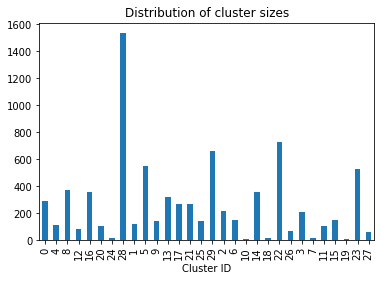

In [11]:
cluster_assignments = pd.DataFrame(mp.cluster_label_for_cases.items(), columns=['id', 'cluster_id'])
cluster_assignments = cluster_assignments.set_index('id')

cluster_sizes = cluster_assignments.cluster_id.value_counts(sort=False)
axes = cluster_sizes.plot.bar()
axes.set_xlabel('Cluster ID')
axes.set_title('Distribution of cluster sizes')



In [12]:
# write the cluster assignments to file
cluster_assignments.to_csv('cluster_assignments_sges123_compare_2019_2020.csv')

In [13]:
cluster_assignments.shape

(7921, 1)

In [14]:
predicted_data = data.join(cluster_assignments)
predicted_data.iloc[0]

Sentiment                                                                           Keep
Category                               Advantages / Disadvantages about Working at Si...
Type                                                        "Recommend Siemens" Comments
Sub Category                                                                         NaN
Machine Translation (beta): English    Well paid, Free working time, More Learning Op...
Detected Language                                                                     en
survey_code                                                                   sges2_2019
year                                                                                2019
cluster_id                                                                             9
Name: 0000ecc475b7ea5c786b7d0b8e1e560d4c004869, dtype: object

In [15]:
predicted_data.shape

(11277, 9)

In [16]:
# get the cluster sizes along with their top words

info = []
for i in range(num_clusters):
    cluster_i_info = {
        'cluster_id': i,
        'cluster_size': cluster_sizes[i]   
    }
    for idx, word in enumerate(mp.cluster_top_words[i]):
        cluster_i_info['top_word_%s' % idx] = word
    info.append(cluster_i_info)

cluster_info = pd.DataFrame(info)
cluster_info = cluster_info.set_index('cluster_id')

cluster_info


,cluster_size,top_word_0,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,top_word_6,top_word_7,top_word_8,top_word_9
cluster_id,,,,,,,,,,,
0,291,work life balanc,work life,life balanc,good work life,life balanc flexibl,balanc flexibl,excel work life,great work life,flexibl work life,condit work life
1,118,good work,good work environ,good work life,good work condit,balanc good work,environ good work,compani good work,good work atmospher,compani good,good facil
2,214,flexibl work hour,work hour,flexibl work,work hour home,work hour possibl,hour home,hour home offic,hour possibl,balanc flexibl work,life balanc flexibl
3,211,work person,person life,work person life,balanc work,balanc work person,person life balanc,good balanc work,good balanc,life balanc,allow good balanc
4,109,excel work,excel work environ,excel work life,work environ,excel work condit,environ excel,condit excel work,condit excel,work condit excel,environ great
5,547,profession develop,person profession,person profession develop,opportun person profession,opportun person,opportun profession,opportun profession develop,good person profession,good person,profession develop siemen
6,145,work condit,good work condit,good work,work condit good,condit good,condit work,work condit work,condit work life,environ work condit,excel work condit
7,16,noth point,point moment,noth point moment,far noth point,far noth,excel noth point,excel noth,two noth point,two noth,balanc two noth
8,368,home offic,hour home,hour home offic,work hour home,possibl home offic,possibl home,home offic possibl,offic possibl,flexibl hour,offic flexibl


In [1]:
sample_cluster = 23
max_docs = 50
for idx, row in list(predicted_data[predicted_data.cluster_id == sample_cluster].iterrows())[:max_docs]:
    print(f'{idx}  {row["Detected Language"]}: {row["Machine Translation (beta): English"]}')

NameError: name 'predicted_data' is not defined

In [18]:
# write the cluster info to file
cluster_info.to_csv('cluster_info_sges123_compare_2019_2020.csv')

## Draw the confusion matrix

In [19]:
# Confusion matrix

import numpy as np
from typing import Tuple
from sklearn.preprocessing import normalize


def non_square_confusion_matrix(actual: List, predicted: List, 
                                actual_ordered: List=None, 
                                predicted_ordered: List=None) -> Tuple[np.ndarray, List[str], List[str]]:
    """Computes a confusion matrix for non-identical classes."""
    assert len(actual) == len(predicted)
    
    if actual_ordered:
        actual_unique = actual_ordered
    else:
        actual_unique = sorted(list(set(actual)))
    actual_indices = {a_label: i for i, a_label in enumerate(actual_unique)}
    print(actual_indices)
    
    if predicted_ordered:
        predicted_unique = predicted_ordered
    else:
        predicted_unique = sorted(list(set(predicted)))
    predicted_indices = {a_label: i for i, a_label in enumerate(predicted_unique)}
    print(predicted_indices)
    
    confmat = np.zeros((len(actual_unique), len(predicted_unique)))
    
    for act,pred in zip(actual, predicted):
        a_idx = actual_indices[act]
        p_idx = predicted_indices[pred]
        confmat[a_idx, p_idx] = confmat[a_idx, p_idx] + 1
    
    return confmat, actual_unique, predicted_unique


def plot_confusion_matrix(cm, true_labels, predicted_labels, 
                          title='Confusion matrix', cmap=None):
    """
    Plots a given confusion matrix

    :param cm: the confusion matrix, a matrix of integers
    :param category_labels: A list of category labels in the same order as the indices of the confusion matrix
    :param title:
    :param cmap: a matplotlib colour map
    :return:
    """

    if not cmap:
        cmap = plt.cm.Blues

    f, ax = plt.subplots(figsize=(16, 6))

    cax = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(predicted_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(predicted_labels, rotation=90)

    tick_marks = np.arange(len(true_labels))
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(true_labels)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    f.colorbar(cax)
    f.tight_layout()

    return f


data_with_clusterid = pd.concat([data, cluster_assignments], axis=1, join='inner')
data_with_clusterid.head()

# Move "Missing" to the end
actual_label_list = data_with_clusterid['Category'].value_counts().index.tolist()
# actual_label_list.append(actual_label_list.pop(actual_label_list.index('Missing')))
        
confmat, actual_names, predicted_names = non_square_confusion_matrix(data_with_clusterid['Category'].tolist(), 
                                                                     data_with_clusterid.cluster_id.tolist(),
                                                                     actual_ordered=actual_label_list,
                                                                     predicted_ordered=range(num_clusters))

print(confmat)
print(actual_names)
print(predicted_names)

plot_confusion_matrix(confmat, actual_names, predicted_names)

norm_confmat = normalize(confmat, axis=1, norm='l1')
plot_confusion_matrix(norm_confmat, actual_names, predicted_names)



ValueError: Shape of passed values is (7927, 9), indices imply (7923, 9)

In [20]:
# predict the 2020 comments
from sta_clustering_core.core.classifier import classify_refcases

distrs, vocab_overlaps = classify_refcases(refcases_2020, mp.model, mp.vec, config)

predicted_cluster_ids = pd.DataFrame(data={'cluster_id': distrs.argmax(axis=1)}, index=[rc.id for rc in refcases_2020])

print(predicted_cluster_ids.head())

                                          cluster_id
e672343e9b13bb15eb338ee2ea53b7660b852afc          14
cf7329c59798d3920821cea4d796d82f0e1687ef          28
005459e721914b1ca4ea3199469980b3ab4f1d86           8
d4592b839417bd8346b2d7958abb877732b5061d           5
73fc2acc79549672f0413b6efee8716ea08d0769          11


In [24]:
# combine the 2019 and 2020 data
counts_2020 = pd.DataFrame(predicted_cluster_ids.cluster_id.value_counts())
counts_2019 = pd.DataFrame(cluster_assignments.cluster_id.value_counts())

counts = counts_2019.join(counts_2020, lsuffix='_2019', rsuffix='_2020')
counts = counts.fillna(0)
counts = counts.assign(cluster_id_2019_perc=counts.cluster_id_2019/cluster_assignments.shape[0]*100)
counts = counts.assign(cluster_id_2020_perc=counts.cluster_id_2020/predicted_cluster_ids.shape[0]*100)
counts = counts.assign(change=counts.cluster_id_2020_perc - counts.cluster_id_2019_perc)
counts.sort_values(by='change')

,cluster_id_2019,cluster_id_2020,cluster_id_2019_perc,cluster_id_2020_perc,change
22,725,176.0,9.152885,5.247466,-3.905419
29,661,175.0,8.344906,5.217651,-3.127255
25,143,23.0,1.805328,0.685748,-1.119579
6,145,27.0,1.830577,0.805009,-1.025568
26,65,0.0,0.820603,0.000000,-0.820603
2,214,64.0,2.701679,1.908169,-0.793510
27,56,0.0,0.706981,0.000000,-0.706981
21,269,93.0,3.396036,2.772809,-0.623227
16,353,131.0,4.456508,3.905784,-0.550724
15,151,51.0,1.906325,1.520572,-0.385753


In [31]:
counts.change.sum()

-4.912736883966318e-15

In [28]:
counts.join(cluster_info).to_csv('cluster_size_change_sges123_compare_2019_2020.')

## View the clustering space with pyLDAvis

In [ ]:
"""Utility functions to prepare data for pyLDAvis."""
from configparser import ConfigParser
from typing import Any
from typing import Dict
from typing import List
from typing import Sequence

from pyLDAvis.sklearn import _get_doc_lengths
from pyLDAvis.sklearn import _get_doc_topic_dists
from pyLDAvis.sklearn import _get_term_freqs
from pyLDAvis.sklearn import _get_topic_term_dists
from sta_clustering_core.core.datamodel import RefCase
from sta_clustering_core.core.features import create_feature_dicts
from sta_clustering_core.core.features import create_weights_vector
from sta_clustering_core.core.model_persistence import ModelPersister


def mp_to_pyldavis_input(
    mdl_perst: ModelPersister, refcases: Sequence[RefCase], config: ConfigParser
) -> Dict[str, Any]:
    """
    Create the input to pyLDAvis.prepare from an MP object.

    See pyLDAvis.sklearn.prepare._extract_data, which this code is adapted from

    Parameters
    ----------
    mdl_perst
    refcases:
        The training data again
    config:
        The same config object as was used to train the model in the first place

    Returns
    -------
    Dict[str, Any]
        The necessary input to pyLDAvis.prepare
    """
    # get all of the config params we need
    weights = create_weights_vector(config)
    min_ngram = config.getint('clustering', 'tokenisation.min_ngram')
    max_ngram = config.getint('clustering', 'tokenisation.max_ngram')

    drop_list_conf_arg = config.get('clustering', 'tokenisation.drop_list')
    if drop_list_conf_arg == 'None':
        drop_list = []
    else:
        drop_list = drop_list_conf_arg.split('|')
    do_stemming = config.getboolean('clustering', 'tokenisation.do_stemming')
    remove_stopwords = config.getboolean(
        'clustering', 'tokenisation.remove_stopwords'
    )
    text_language = config.get('clustering', 'tokenisation.text_language')
    parallelisation = config.getint('clustering', 'features.parallelisation')

    lda_model = mdl_perst.model
    feat_dicts = create_feature_dicts(
        refcases,
        weights,
        min_ngram,
        max_ngram,
        do_stemming,
        parallelisation,
        drop_list,
        text_language,
        remove_stopwords,
    )
    
    # drop empty documents, ie with no non-zero features
    feat_dicts = [fd for fd in feat_dicts if fd]
    
    dtm = mdl_perst.vec.transform(feat_dicts)
#     print(type(dtm))
#     print('nans?')
#     dtm_sums = dtm.sum(axis=1)
#     print(dtm_sums[np.isnan(dtm_sums)])
#     print(dtm_sums[dtm_sums == 0.0])

    vocab: List[str] = mdl_perst.vec.feature_names_
    doc_lengths = _get_doc_lengths(dtm)
    term_freqs = _get_term_freqs(dtm)
    topic_term_dists = _get_topic_term_dists(lda_model)

    assert term_freqs.shape[0] == len(vocab), (
        'Term frequencies and vocabulary '
        'are of different sizes, {} != {}.'.format(
            term_freqs.shape[0], len(vocab)
        )
    )

    assert topic_term_dists.shape[1] == dtm.shape[1], (
        'Topic-term distributions and document-term matrix'
        ' have different number of columns, {} != {}.'.format(
            topic_term_dists.shape[1], len(vocab)
        )
    )

    # column dimensions of document-term matrix and topic-term distributions
    # must match first before transforming to document-topic distributions
    doc_topic_dists = _get_doc_topic_dists(lda_model, dtm)

    return {
        'vocab': vocab,
        'doc_lengths': doc_lengths,  # .tolist(),
        'term_frequency': term_freqs,  # .tolist(),
        'doc_topic_dists': doc_topic_dists,  # .tolist(),
        'topic_term_dists': topic_term_dists  # .tolist()
    }

In [ ]:
import pyLDAvis
# from sges_sop_it.pyldavis_wrapper import mp_to_pyldavis_input

pyLDAvis.enable_notebook()

# pyldavis_input = mp_to_pyldavis_input(mp, refcases, config)

vis_nmf = pyLDAvis.prepare(**pyldavis_input)


In [ ]:
# display the pyLDAvis
vis_nmf

In [ ]:
with open('pyldavis_sges123_k50.html', 'w', encoding='utf8') as f:
    pyLDAvis.save_html(vis_nmf, f)